# 과제 조건


(1) 'please_select_the_gender_of_the_person_in_the_picture' 열의 값을 사용하여 남자 100명이상, 여자 100명이상을 선택하고 

(2) 선택된 200명이상의 이미지를 'image_url' 를 통해서 읽어들이세요

(3) 데이터로딩이 제대로 되었는지 확인을 위해 이미지중에 하나를 출력하고

(4) 간단한 normalization 을 진행하세요

(5) 읽어들인 이미지를 train:test=8:2로 분리하여

(6) 남자, 여자를 구분하는 CNN 모델을 만들고 

(7) acc와 loss 그래프를 출력하세요. 최소성능기준:최근 5번의 iteration에서 분류정확도 80%

</br>


## 라이브러리 import

</br>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import random

from tensorflow import keras
from  tensorflow.keras.optimizers import Adam 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, metrics

</dr>

## 데이터 필터링 

1. nan 값을 가지고 있거나, male, female 외 값을 가지고 있다면 drop 한다
    - 다양한 필터링을 시도해 보았지만 이 결과가 가장 잘 필터링 된다.
2. 각각 100 장 이상의 이미지를 불러오기 위해 성별 별로 데이터를 분리한다
    - 향후 데이터에 접근을 쉽게하기 위해 index 배열을 따로 만들어준다
    - 잘 분리되었는지 print 해본다

</dr>

In [18]:
data = pd.read_csv('./Info_Images.csv')


data = data.dropna(subset=['image_url'])
data = data.dropna(subset=['please_select_the_gender_of_the_person_in_the_picture'])
data = data[(data["please_select_the_gender_of_the_person_in_the_picture"]
                      .isin(["male", "female"])) & (~data["please_select_the_gender_of_the_person_in_the_picture"]
                      .isna())]
# data = data[(data["please_select_the_gender_of_the_person_in_the_picture_gold"]
#                       .isin(["male", "female",'female\nunsure', 'male\nunsure'])) & (~data["please_select_the_gender_of_the_person_in_the_picture_gold"]
#                       .isna())]

#data = data[data["please_select_the_gender_of_the_person_in_the_picture:confidence"] == 1]

data = data.loc[:,['image_url', 'please_select_the_gender_of_the_person_in_the_picture']]
data_male = data.loc[data["please_select_the_gender_of_the_person_in_the_picture"] == "male"]
data_female = data.loc[data["please_select_the_gender_of_the_person_in_the_picture"] == "female"]

print(len(data_female))
print(len(data_male))
print(data_female.index)
print(data_male.index)


7367
47595
Int64Index([   15,    41,    94,   135,   147,   162,   172,   184,   198,
              235,
            ...
            63993, 64004, 64007, 64011, 64012, 64028, 64030, 64033, 64045,
            64068],
           dtype='int64', length=7367)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            64073, 64074, 64075, 64076, 64077, 64078, 64079, 64080, 64082,
            64083],
           dtype='int64', length=47595)


In [19]:
# 상위 5000개만 추출 사실 필요 없지만 향후 관리를 위해....
data_male_sample = data_male.iloc[:47595,:]
data_female_sample = data_female.iloc[:7367,:]
print(data_male_sample['please_select_the_gender_of_the_person_in_the_picture'].unique())
print(data_female_sample['please_select_the_gender_of_the_person_in_the_picture'].unique())

['male']
['female']


</br>

## 데이터 크롤링

</br>

데이터를 크롤링한다. 
- 간혹 성공적으로 크롤링을 해오지 못하는 경우가 있어 예외 처리문을 작성한다
- 확인 결과 이미지 별 크기는 300 x 300 으로 같지만 channel이 다르다
- 이후 과정 진행을 위해 grayscale로 통일해주었으며 크기도 150 x150 으로 통일하였다
- 데이터셋의 크기는 남여 각 3000 장의 이미지로 총 6000장이다
- 이미지가 잘 로드 되었는지 출력해본다 

generating done :  3000


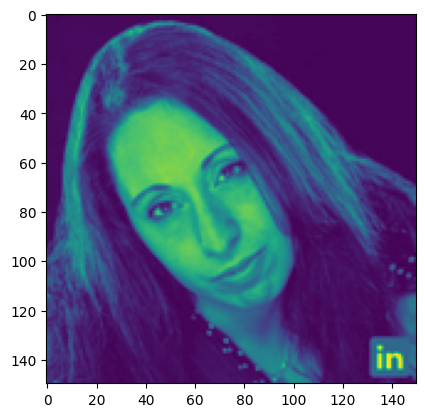

generating done :  6000


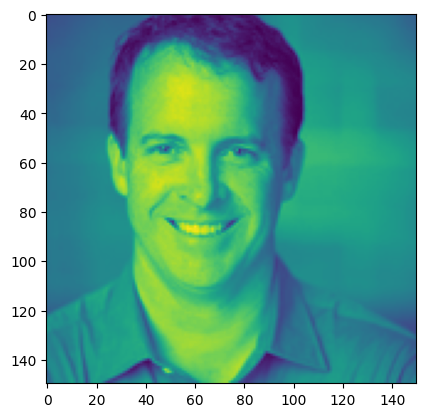

============== data generated !! ==============


In [20]:
data_set_size = 3000
data = []
i = 0
j = 0

while True:
    index = random.randrange(0,len(data_female_sample.index))
    url = data_female_sample["image_url"][data_female_sample.index[i]]
    i = i + 1
    # URL에서 이미지 데이터 가져오기
    response = requests.get(url)
    try:
        # BytesIO로 이미지 데이터 처리하기
        img = Image.open(BytesIO(response.content))
        
        # 이미지 별 channel 이 다르기 때문에 gray scale로 통일후 차원 증가        # 차원도 하나 증가시켜야함
        img = img.convert("L")
        img = img.resize((150, 150))
        img_array = np.asarray(img)
        img_array = np.expand_dims(img_array, axis=-1) 
        #img_array = np.repeat(img_array, 3, axis=-1) 
        #print(img_array.shape)
               
        # dataset에 label 과 추가 female -> 0 
        data.append((img_array,0))
    # 이미지 로드 fail시 출력
    except:
        print("Warning: Failed to fetch image from URL")
        
    if len(data) == data_set_size :
        print("generating done : " ,len(data))
        # 이미지 플롯으로 표시하기
        plt.imshow(img_array)
        plt.show()
        break
    
# for male
while True:
    index = random.randrange(0,len(data_male_sample.index))
    url = data_male_sample["image_url"][data_male_sample.index[j]]
    j = j + 1
    # URL에서 이미지 데이터 가져오기
    response = requests.get(url)
    try:
        # BytesIO로 이미지 데이터 처리하기
        img = Image.open(BytesIO(response.content))
   
        # 이미지 별 channel 이 다르기 때문에 gray scale로 통일후 차원 증가
        img = img.convert("L")
        img = img.resize((150, 150))
        img_array = np.asarray(img)
        img_array = np.expand_dims(img_array, axis=-1) 
        #img_array = np.repeat(img_array, 3, axis=-1) 
        #print(img_array.shape)
   
        # print(img_array) male -> 1 
        data.append((img_array,1))
        
    # 이미지 로드 fail시 출력
    except:
        print("Warning: Failed to fetch image from URL")
        
    if len(data) == data_set_size*2 :
        print("generating done : " ,len(data))
        plt.imshow(img_array)
        plt.show()
        break
    
print("============== data generated !! ==============")


## tip! 매번 로드하면 너무 오래 걸리니까 저장해서 쓰자!!! 

In [11]:
#np.savez('my_arrays.npz', arr1=target, arr2=data_in)
data = np.load("my_arrays.npz")
data_in = data['arr1']
data_in

array([0, 0, 0, ..., 1, 0, 1])

## 데이터셋 생성

- 읽어들인 이미지를 train:test=8:2로 분리한다
- 분리한 데이터를 각각 픽셀 최댓값인 255 로 나눠 normalization 을 해준다.

In [12]:
target = data['arr1']
data_in = data['arr2']

x_train,x_test,  y_train,  y_test = train_test_split(
            data_in, target, test_size=0.2, shuffle=True, stratify=target, random_state=34)

#normalize array(img)
x_train = np.asarray( x_train) / 255.0
x_test = np.asarray( x_test) / 255.0
y_train = np.asarray( y_train) / 1.0
y_test = np.asarray( y_test) / 1.0

print("\n\nData Read Done!")
print("Training X Size : " + str( x_train.shape))
print("Training Y Size : " + str( y_train.shape))
print("Test X Size : " + str( x_test.shape))
print("Test Y Size : " + str( y_test.shape) + '\n\n')



Data Read Done!
Training X Size : (4800, 150, 150, 1)
Training Y Size : (4800,)
Test X Size : (1200, 150, 150, 1)
Test Y Size : (1200,)




## 남자, 여자를 구분하는 CNN 모델

- 수업시간 코드를 기반으로 하나의 Conv2D 레이어추가, filter 수를 두배로 증폭, dropout추가를 통해 성능을 높였다
- 최소성능기준:최근 5번의 iteration에서 분류정확도 80% 를 가뿐히 만족한다!
- acc와 loss 그래프로 시각화 또한 진행하였다
    - 적당한 시점에 early stopping 된것을 알 수 있다 



In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,1)))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #2*2에서 가장큰값을 추출

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())#활성화함수를 사용하기전에 2차원을 1차원으로 바꿔줌
# Feature Extraction -> Classification
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))# 과적합을 피하기 위해서 dropout 사용. 50% 노드를 사용
model.add(Dense(2)) #최종출력 노드의 수는 클래스 갯수와 같은 2개로
model.add(Activation('softmax'))

model.compile(optimizer = Adam(learning_rate= 0.0002), metrics=['accuracy'],
              loss = 'sparse_categorical_crossentropy')
print("model definded\n\n", model.summary)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
early_stop2 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)

history = model.fit(x_train, y_train, epochs=32,batch_size = 16,
                    validation_data=(x_test, y_test), callbacks=[early_stop, early_stop2])

res = model.evaluate(x_test, y_test, verbose=0)
print("acc is : ", res[1]* 100)


model definded

 <bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f869cc55bd0>>
Epoch 1/32
300/300 [==============================] - 6s 18ms/step - loss: 0.6826 - accuracy: 0.5458 - val_loss: 0.6332 - val_accuracy: 0.6117
Epoch 2/32
300/300 [==============================] - 5s 16ms/step - loss: 0.5979 - accuracy: 0.6696 - val_loss: 0.5329 - val_accuracy: 0.7392
Epoch 3/32
300/300 [==============================] - 5s 17ms/step - loss: 0.5276 - accuracy: 0.7340 - val_loss: 0.5448 - val_accuracy: 0.7167
Epoch 4/32
300/300 [==============================] - 5s 17ms/step - loss: 0.4713 - accuracy: 0.7708 - val_loss: 0.4688 - val_accuracy: 0.7533
Epoch 5/32
300/300 [==============================] - 5s 17ms/step - loss: 0.4385 - accuracy: 0.7925 - val_loss: 0.4681 - val_accuracy: 0.7750
Epoch 6/32
300/300 [==============================] - 5s 17ms/step - loss: 0.4435 - accuracy: 0.7892 - val_loss: 0.4547 - val_accuracy: 0.7733
Epoch 7/32
300/300 [===========

## 시각화1 

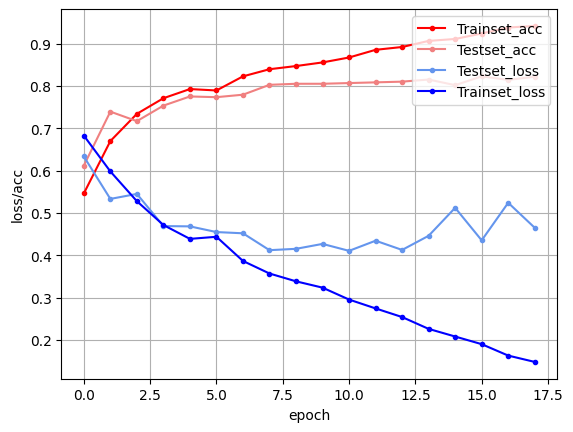

In [22]:
#결과를 그래프로 표현하는 부분입니다.
acc= history.history['accuracy'] # training
val_acc= history.history['val_accuracy'] # test
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))  
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right') 
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

## 시각화2

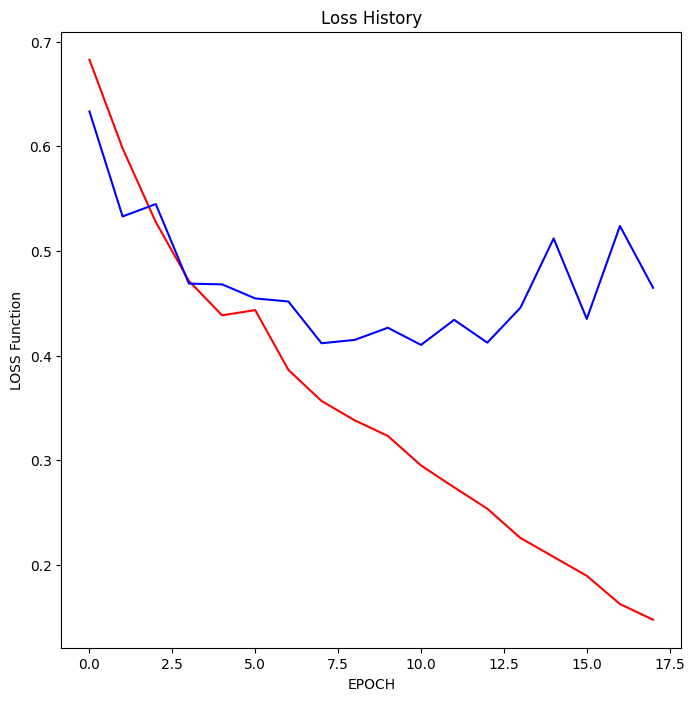

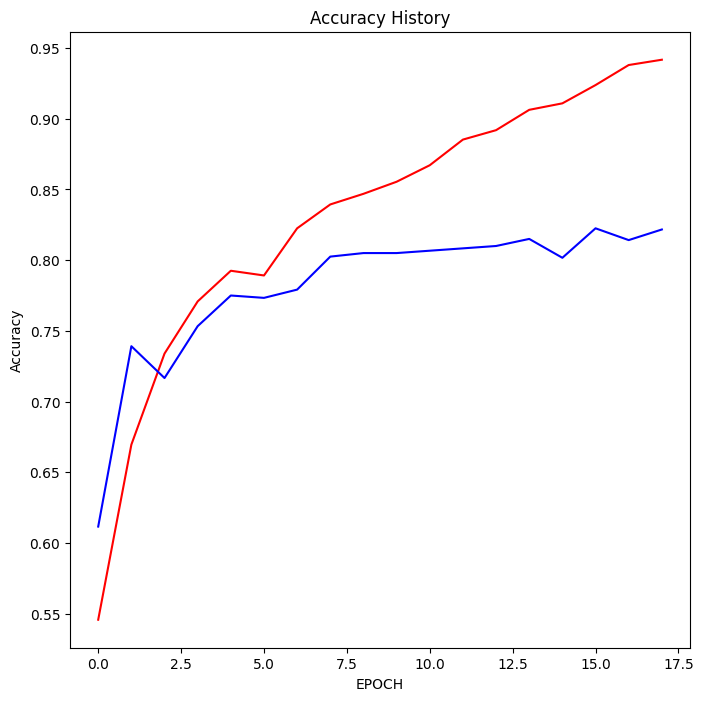

In [23]:
train_history = history.history["loss"]
validation_history = history.history["val_loss"]
fig = plt.figure(figsize=(8, 8))
plt.title("Loss History")
plt.xlabel("EPOCH")
plt.ylabel("LOSS Function")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')

train_history = history.history["accuracy"]
validation_history = history.history["val_accuracy"]
fig = plt.figure(figsize=(8, 8))
plt.title("Accuracy History")
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
